<a href="https://colab.research.google.com/github/Teasotea/BioNER-and-RD/blob/main/KnowledgeGraps.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [2]:
import os
import math
import random
import csv
import sys

import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import statistics as stats

In [3]:
import nltk
from nltk.tokenize import TreebankWordTokenizer as twt
import spacy
from spacy import displacy

In [4]:
import pickle
from google.colab import files

In [5]:
import bs4
import requests
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [6]:
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



# Load Data

In [10]:
with open('/content/data0.txt') as f:
      eval_article = f.read()

In [11]:
train_df = pd.read_csv('/content/cdr_dner_train_df.csv')
test_df = pd.read_csv('/content/cdr_dner_test_df.csv')
dev_df = pd.read_csv('/content/cdr_dner_dev_df.csv')

In [12]:
CID_train_df = train_df[train_df['xloc'] == "CID"].reset_index(drop=True)
DNER_train_df = train_df[train_df['xloc'] != "CID"].reset_index(drop=True)

CID_test_df = test_df[test_df['xloc'] == "CID"].reset_index(drop=True)
DNER_test_df = test_df[test_df['xloc'] != "CID"].reset_index(drop=True)

CID_dev_df = dev_df[dev_df['xloc'] == "CID"].reset_index(drop=True)
DNER_dev_df = dev_df[dev_df['xloc'] != "CID"].reset_index(drop=True)

In [13]:
iob_train = pd.read_csv('/content/iob_train.csv',converters={"tokens": lambda x: x.strip("[]").replace("'","").split(", "), "iob_tags": lambda x: x.strip("[]").replace("'","").split(", ")})
iob_test = pd.read_csv('/content/iob_test.csv',converters={"tokens": lambda x: x.strip("[]").replace("'","").split(", "), "iob_tags": lambda x: x.strip("[]").replace("'","").split(", ")})
iob_dev = pd.read_csv('/content/iob_dev.csv',converters={"tokens": lambda x: x.strip("[]").replace("'","").split(", "), "iob_tags": lambda x: x.strip("[]").replace("'","").split(", ")})

In [14]:
iob_dev

,tokens,iob_tags
0,"[Tricuspid, valve, regurgitation, and, lithium, carbonate, toxicity, in, a, newborn, infant., A, newborn, with, massive, tricuspid, regurgitation, ,, atrial, flutter, ,, congestive, heart, failure...","[B-Disease, I-Disease, I-Disease, O, B-Chemical, I-Chemical, B-Disease, O, O, O, O, O, O, O, O, B-Disease, I-Disease, O, B-Disease, I-Disease, O, B-Disease, I-Disease, I-Disease, O, O, O, O, O, B-..."
1,"[Phenobarbital-induced, dyskinesia, in, a, neurologically-impaired, child., A, 2-year-old, child, with, known, neurologic, impairment, developed, a, dyskinesia, soon, after, starting, phenobarbita...","[B-Chemical, B-Disease, O, O, B-Disease, O, O, O, O, O, O, B-Disease, I-Disease, O, O, B-Disease, O, O, O, B-Chemical, O, O, B-Disease, O, O, O, B-Disease, I-Disease, O, O, O, O, O, O, O, O, B-Che..."
2,"[Acute, changes, of, blood, ammonia, may, predict, short-term, adverse, effects, of, valproic, acid., Valproic, acid, (, VPA, ), was, given, to, 24, epileptic, patients, who, were, already, being,...","[O, O, O, O, B-Chemical, O, O, O, O, O, O, B-Chemical, O, B-Chemical, I-Chemical, O, B-Chemical, O, O, O, O, O, B-Disease, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-Chemical, O, O, O, O, O, O..."
3,"[Effects, of, calcitonin, on, rat, extrapyramidal, motor, system, :, behavioral, and, biochemical, data., The, effects, of, i.v.c., injection, of, human, and, salmon, calcitonin, on, biochemical, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-Chemical, B-Disease, O, O, O, O, O, B-Chemical, B-Di..."
4,"[Development, of, isoproterenol-induced, cardiac, hypertrophy., The, development, of, cardiac, hypertrophy, was, studied, in, adult, female, Wistar, rats, following, daily, subcutaneous, injection...","[O, O, B-Chemical, B-Disease, O, O, O, O, B-Disease, I-Disease, O, O, O, O, O, O, O, O, O, O, O, O, B-Chemical, O, B-Chemical, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
...,...,...
487,"[Reversible, cerebral, lesions, associated, with, tiazofurin, usage, :, MR, demonstration., Tiazofurin, is, an, experimental, chemotherapeutic, agent, currently, undergoing, clinical, evaluation.,...","[O, B-Disease, I-Disease, O, O, B-Chemical, O, O, O, O, B-Chemical, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-Disease, I-Disease, O, O, O, O, O, O, O, O, O, O, O, O, O, O..."
488,"[Antagonism, of, diazepam-induced, sedative, effects, by, Ro15-1788, in, patients, after, surgery, under, lumbar, epidural, block., A, double-blind, placebo-controlled, investigation, of, efficacy...","[O, O, B-Chemical, O, O, O, B-Chemical, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-Chemical, O, O, O, O, O, B-Chemical, O, O, O, O, O, O, O, O, O, O, O, O, ..."
489,"[Enhanced, stimulus-induced, neurotransmitter, overflow, in, epinephrine-induced, hypertensive, rats, is, not, mediated, by, prejunctional, beta-adrenoceptor, activation., The, present, study, exa...","[O, O, O, O, O, B-Chemical, B-Disease, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-Chemical, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-Chemical, O, O, B..."
490,"[Ocular, manifestations, of, juvenile, rheumatoid, arthritis., We, followed, 210, cases, of, juvenile, rheumatoid, arthritis, closely, for, eleven, years., Thirty-six, of, the, 210, patients, (, 1...","[O, O, O, B-Disease, I-Disease, O, O, O, O, O, O, B-Disease, I-Disease, I-Disease, O, O, O, O, O, O, O, O, O, O, O, O, O, O, B-Disease, B-Disease, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O..."


# BERT-sklearn

In [ ]:
!git clone -b master https://github.com/charles9n/bert-sklearn
!cd bert-sklearn; pip install .
import os
os.chdir("bert-sklearn")
print(os.listdir())

In [ ]:
# !pip install --upgrade botocore==1.23.26
# !pip install --upgrade urllib3==1.22.0

In [ ]:
# !pip install --upgrade sagemaker

In [ ]:
from bert_sklearn import BertTokenClassifier
from bert_sklearn import load_model

In [ ]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [ ]:
train = iob_train.append(iob_dev, ignore_index=True)
train = train.reset_index(drop = True)
print("Train and dev data: %d sentences, %d tokens"%(len(train), len(flatten(train.tokens.tolist()))))
print("Test data: %d sentences, %d tokens"%(len(iob_test), len(flatten(iob_test.tokens))))

In [ ]:
X_train, y_train = train.tokens, train.iob_tags
X_test, y_test = iob_test.tokens, iob_test.iob_tags

In [ ]:
y_train

In [ ]:
label_list = list(np.unique(flatten(y_train)))
print("\nNER tags:", label_list)

In [ ]:
train.head()

### Finetune SciBERT

1) Use `'scibert-scivocab-cased'` model. [GitHub](https://github.com/allenai/scibert), [paper](https://arxiv.org/pdf/1903.10676.pdf)

2) Set the **`ignore_label`** =`['O']`. Exclude the non named entities.

3) Set the **` max_seq_len`** = 256 - high enough to cover lengths of the token lists

In [ ]:
%%time
scibert_model = BertTokenClassifier('scibert-scivocab-cased',
                            max_seq_length=64,
                            epochs=3,
                            gradient_accumulation_steps=2,
                            learning_rate=3e-5,
                            train_batch_size=16,
                            eval_batch_size=16,
                            validation_fraction=0.,                            
                            label_list=label_list,
                            ignore_label=['O'])



scibert_model.fit(X_train, y_train)

In [ ]:
scibert_f1_test = scibert_model.score(X_test, y_test,'macro')
print("Test f1: %0.02f"%(scibert_f1_test))

In [ ]:
scibert_y_preds = scibert_model.predict(X_test)
print(classification_report(flatten(y_test), flatten(scibert_y_preds)))

In [ ]:
iter_zip = zip(flatten(X_test),flatten(y_test),flatten(scibert_y_preds))
preds = [" ".join([token, y, y_pred]) for token, y, y_pred in iter_zip]
with open("preds.txt",'w') as f:
    for x in preds:
        f.write(str(x)+'\n') 

!perl ./other_examples/conlleval.pl < preds.txt
!rm preds.txt

In [ ]:
num = 28
tokens = X_test[num]
labels = y_test[num]
scibert_preds  = scibert_y_preds[num]

In [ ]:
data = {"token": tokens,"label": labels, "scibert": scibert_preds}
df=pd.DataFrame(data=data)
df.head(50)

### Hyperparameter Tuning

In [ ]:
# from sklearn.model_selection import GridSearchCV

# params = {'epochs':[3, 4], 'learning_rate':[2e-5, 3e-5, 5e-5]}

# scibert_clf = GridSearchCV(BertTokenClassifier('scibert-scivocab-cased',
#                             max_seq_length=256,
#                             gradient_accumulation_steps=2,
#                             train_batch_size=16,
#                             eval_batch_size=16,
#                             validation_fraction=0.,                            
#                             label_list=label_list,
#                             ignore_label=['O']), 
#                    params,
#                    verbose=True)

# scibert_clf.fit(X_train ,y_train)

# Results of DNER task with SciBERT

In [15]:
eval_data = pd.Series(eval_article.split('\n'))
tokenized_eval_data = eval_data.apply(lambda x:list(twt().tokenize(x)))
tokenized_eval_data

0      [Transductional, analysis, was, applied, to, the, Pseudomonas, aeruginosa, mutant, PAO14, (, hnc-1, ), ., This, mutant, can, utilize, L-histidinol, as, sole, source, of, carbon, and, nitrogen, and...
1      [Bacteriocins, produced, by, six, strains, of, Rhizobium, trifolii, were, found, to, be, of, the, relatively, low, molecular, weight, ,, non-phage, type., The, molecular, weights, ranged, from, ap...
2      [The, gamma, haemolysin, of, Staphylococcus, aureus, \'Smith, 5R\, ', was, produced, on, Dolman-Wilson, agar, overlain, with, cellophane., Maximal, yields, of, crude, lysin, with, titres, of, 2000...
3      [Arginine, and, methionine, transport, by, Aspergillus, nidulans, mycelium, was, investigated., A, single, uptake, system, is, responsible, for, the, transport, of, arginine, ,, lysine, and, ornit...
4      [Aphids, transmitted, poly-L-ornithine, (, PLO, ), -treated, tobacco, mosaic, virus, (, TMV, ), when, given, acquistion, and, inoculation, access, periods, as, brief

In [ ]:
# # # save the model to disk
# # scibert_model_file = '/content/scibert_model.sav'
# # pickle.dump(scibert_model, open(scibert_model_file, 'wb'))

# # load the model from disk
# loaded_model = pickle.load(open(scibert_model_file, 'r'))
# # loaded_model = pd.read_pickle(open(scibert_model_file, 'r'))

In [ ]:
# result = loaded_model.score(X_test, y_test)

In [ ]:
# files.download('scibert_model.sav')

In [ ]:
eval_predicts_scibert = scibert_model.predict(tokenized_eval_data)

In [ ]:
print(eval_predicts_scibert[4])

In [ ]:
print(len(eval_predicts_scibert), len(eval_data.tolist()))

In [ ]:
def locate_entities(text, annots):
  loc_list = []
  span_list = list(twt().span_tokenize(text))
  for annotation, loc in zip(annots, span_list):
    if annotation != 'O':
      loc = (loc[0], loc[1], str(annotation))
      loc_list.append(loc)
  return loc_list

In [ ]:
eval_data_entities = [locate_entities(x,y) for x, y in zip(eval_data.tolist(), eval_predicts_scibert)]
eval_data_entities[99]

In [ ]:
def display_entities(eval_data, num):
  if len(eval_data_entities[num]) == 0:
    return eval_data
  scibert_annot_data = [(eval_data.tolist()[num],
  {'entities': eval_data_entities[num]})]
  options = {"ents": ['B-Chemical', 'B-Disease','I-Chemical', 'I-Disease'], "colors": {'B-Chemical': "#85C1E9", "B-Disease": "#ff6961", 'I-Chemical': "#85C1E9", "I-Disease": "#ff6961"}}
  nlp = spacy.blank('en')
  raw_text = scibert_annot_data[0][0]
  doc = nlp.make_doc(raw_text)
  spans = scibert_annot_data[0][1]["entities"]
  ents = []
  for span_start, span_end, label in spans:
    ent = doc.char_span(span_start, span_end, label=label)
    if ent is None:
        continue
    ents.append(ent)
  doc.ents = ents
  displacy.render(doc, style="ent",options=options, jupyter=True)

In [ ]:
display_entities(eval_data, 99)

In [ ]:
for i in range(5,15):
  display_entities(eval_data, i)

# Relation Extraction

In [16]:
CID_train_df["text"] = CID_train_df.apply(lambda x: x['title_source_text']+ ' '+x['source_text'], axis = 1)
CID_test_df["text"] = CID_test_df.apply(lambda x: x['title_source_text']+ ' '+x['source_text'], axis = 1)
CID_dev_df["text"] = CID_dev_df.apply(lambda x: x['title_source_text']+ ' '+x['source_text'], axis = 1)

CID_train_df = CID_train_df.drop(columns = ['entity', 'name_id', 'title_source_text', 'source_text', 'xloc'])
CID_test_df = CID_test_df.drop(columns = ['entity', 'name_id', 'title_source_text', 'source_text', 'xloc'])
CID_dev_df = CID_dev_df.drop(columns = ['entity', 'name_id', 'title_source_text', 'source_text', 'xloc'])

In [17]:
CID_train_df = CID_train_df[CID_train_df['name'].str.startswith('D') & CID_train_df['yloc'].str.startswith('D')]
CID_test_df = CID_test_df[CID_test_df['name'].str.startswith('D') & CID_test_df['yloc'].str.startswith('D')]
CID_dev_df = CID_dev_df[CID_dev_df['name'].str.startswith('D') & CID_dev_df['yloc'].str.startswith('D')]

In [18]:
CID_train_df.head()

,text_id,yloc,name,text
0,354896,D008012,D006323,Lidocaine-induced cardiac asystole. Intravenous administration of a single 50-mg bolus of lidocaine in a 67-year-old man resulted in profound depression of the activity of the sinoatrial and atrio...
1,435349,D013390,D005207,Suxamethonium infusion rate and observed fasciculations. A dose-response study. Suxamethonium chloride (Sch) was administered i.v. to 36 adult males at six rates: 0.25 mg s-1 to 20 mg s-1. The inf...
2,603022,D012601,D062787,"Galanthamine hydrobromide, a longer acting anticholinesterase drug, in the treatment of the central effects of scopolamine (Hyoscine). Galanthamine hydrobromide, an anticholinesterase drug capable..."
3,1378968,D008094,D006973,"Effects of uninephrectomy and high protein feeding on lithium-induced chronic renal failure in rats. Rats with lithium-induced nephropathy were subjected to high protein (HP) feeding, uninephrecto..."
4,1378968,D008094,D011507,"Effects of uninephrectomy and high protein feeding on lithium-induced chronic renal failure in rats. Rats with lithium-induced nephropathy were subjected to high protein (HP) feeding, uninephrecto..."


In [19]:
DNER_train_df = DNER_train_df[DNER_train_df['name_id'].str.startswith('D') == True]
DNER_test_df = DNER_test_df[DNER_test_df['name_id'].str.startswith('D') == True]
DNER_dev_df = DNER_dev_df[DNER_dev_df['name_id'].str.startswith('D') == True]

In [20]:
test_names_df = pd.DataFrame(zip(DNER_train_df["name_id"].unique(), DNER_train_df['name'].unique()), columns=["name_id", "name"])

In [21]:
test_names_df.head()

,name_id,name
0,D009270,Naloxone
1,D003000,clonidine
2,D006973,hypertensive
3,D007022,hypotensive
4,D008750,alpha-methyldopa


In [24]:
DNER_train_df = DNER_train_df[DNER_train_df['xloc'].str.isnumeric() & DNER_train_df['yloc'].str.isnumeric()]
DNER_test_df = DNER_test_df[DNER_test_df['xloc'].str.isnumeric() & DNER_test_df['yloc'].str.isnumeric()]
DNER_dev_df = DNER_dev_df[DNER_dev_df['xloc'].str.isnumeric() & DNER_dev_df['yloc'].str.isnumeric()]

DNER_train_df = DNER_train_df.astype({"xloc": int, "yloc": int}, errors='raise')
DNER_test_df = DNER_test_df.astype({"xloc": int, "yloc": int}, errors='raise')
DNER_dev_df = DNER_dev_df.astype({"xloc": int, "yloc": int}, errors='raise')

DNER_train_df["text"] = DNER_train_df.apply(lambda x: x['title_source_text']+ ' '+x['source_text'], axis = 1)
DNER_train_df["loc"] = DNER_train_df.apply(lambda x: tuple((x['xloc'],x['yloc'])), axis = 1)

DNER_test_df['text'] = DNER_test_df.apply(lambda x: x['title_source_text']+ ' '+x['source_text'], axis = 1)
DNER_test_df["loc"] = DNER_test_df.apply(lambda x: tuple((x['xloc'],x['yloc'])), axis = 1)

DNER_dev_df['text'] = DNER_dev_df.apply(lambda x: x['title_source_text']+ ' '+x['source_text'], axis = 1)
DNER_dev_df["loc"] = DNER_dev_df.apply(lambda x: tuple((x['xloc'],x['yloc'])), axis = 1)

In [25]:
train_data_text_unp = pd.DataFrame(DNER_train_df["text"].unique(), columns=["sent"])
train_data_text_unp['tokens'] = train_data_text_unp.sent.apply(lambda x: list(twt().tokenize(x)))

test_data_text_unp = pd.DataFrame(DNER_test_df["text"].unique(), columns=["sent"])
test_data_text_unp['tokens'] = test_data_text_unp.sent.apply(lambda x: list(twt().tokenize(x)))

dev_data_text_unp = pd.DataFrame(DNER_dev_df["text"].unique(), columns=["sent"])
dev_data_text_unp['tokens'] = dev_data_text_unp.sent.apply(lambda x: list(twt().tokenize(x)))

In [26]:
def get_items( source_df, item="entity"):
  items_by_text = []
  for i in source_df["text"].unique():
    items_list = source_df[source_df["text"] == i][item].tolist()
    items_by_text.append(items_list)
  return items_by_text

def extend_df(df, source_d = DNER_train_df):
  df['entities'] = get_items(source_d,item="entity")
  df['names'] = get_items(source_d,item="name")
  df['loc'] = get_items(source_d,item="loc")
  df['name_ids'] = get_items(source_d,item="name_id")
  return df

In [27]:
train_data_text_unp = extend_df(train_data_text_unp, source_d = DNER_train_df)
test_data_text_unp = extend_df(test_data_text_unp, source_d = DNER_test_df)
dev_data_text_unp = extend_df(dev_data_text_unp, source_d = DNER_dev_df)

In [30]:
unique_train_data = train_data_text_unp['sent']

0      Naloxone reverses the antihypertensive effect of clonidine. In unanesthetized, spontaneously hypertensive rats the decrease in blood pressure and heart rate produced by intravenous clonidine, 5 to...
1      Lidocaine-induced cardiac asystole. Intravenous administration of a single 50-mg bolus of lidocaine in a 67-year-old man resulted in profound depression of the activity of the sinoatrial and atrio...
2      Suxamethonium infusion rate and observed fasciculations. A dose-response study. Suxamethonium chloride (Sch) was administered i.v. to 36 adult males at six rates: 0.25 mg s-1 to 20 mg s-1. The inf...
3      Galanthamine hydrobromide, a longer acting anticholinesterase drug, in the treatment of the central effects of scopolamine (Hyoscine). Galanthamine hydrobromide, an anticholinesterase drug capable...
4      Effects of uninephrectomy and high protein feeding on lithium-induced chronic renal failure in rats. Rats with lithium-induced nephropathy were subjected to high pro

In [34]:
doc = nlp(unique_train_data.iloc[0])
for tok in doc:
  print(tok.text, "...", tok.dep_)
  break

Naloxone ... nsubj


In [35]:
def get_entities(sent):
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

In [39]:
print(get_entities(unique_train_data.iloc[0]))
print(get_entities(unique_train_data.iloc[5]))
print(get_entities(unique_train_data.iloc[14]))

['functional receptor antagonism', 'sympathetic alpha tone']
['role', 'treatment']
['labetalol', 'advantages']


In [40]:
entity_pairs = []

for i in tqdm(unique_train_data):
  entity_pairs.append(get_entities(i))

100%|██████████| 489/489 [00:31<00:00, 15.31it/s]


In [41]:
entity_pairs[46:57]

[['clinicians', 'unknown  origin'],
 ['widespread  triad', 'beta lactam antibiotics'],
 ['carefully side effects', 'particular  patient'],
 ['antithrombosis', 'mainly antiplatelet aggregation activities'],
 ['New chemotherapy combinations', 'advanced  NSCLC'],
 ['apparently calcification they', 'calcification sites'],
 ['hyperthymic  who', 'greater mood switches'],
 ['high guarana health case', 'such  products'],
 ['2 respiratory cases', 'continuous dilatation mimicking fentanyl'],
 ['cumulative  HAART', 'LA transgenic mice'],
 ['oral  they', 'prothrombotic  mutation']]

In [69]:
sent_tokenized_eval_data = eval_data.apply(lambda x:x.split('. '))
sent_tokenized_eval_data.iloc[2]

["The gamma haemolysin of Staphylococcus aureus \\'Smith 5R\\' was produced on Dolman-Wilson agar overlain with cellophane",
 'Maximal yields of crude lysin with titres of 2000 to 4000 haemolytic units/ml were obtained within 24 h at 37 degrees C in 10% (v/v) CO2 in air, on medium adjusted to pH 7-0',
 'The crude lysin was purified 2700-fold (with 75% recovery) by ultrafiltration, gel filtration and ammonium sulphate fractionation',
 'The specific activity of the lysin was 10(5) haemolytic units/mg protein after the dialysed active precipitate was extracted with NaCl and reprecipitated with ammonium sulphate',
 'Purified gamma lysin was homogeneous by disc electrophoresis and immunoelectrophoresis.']

In [70]:
sent_tokenized_eval_data = pd.DataFrame(sent_tokenized_eval_data, columns= ["paragraph"])

In [71]:
sent_tokenized_eval_data['entity pairs'] = sent_tokenized_eval_data["paragraph"].apply(lambda x: [get_entities(i) for i in x])

In [72]:
sent_tokenized_eval_data

,paragraph,entity pairs
0,"[Transductional analysis was applied to the Pseudomonas aeruginosa mutant PAO14 (hnc-1), This mutant can utilize L-histidinol as sole source of carbon and nitrogen and has a 60-fold increased hist...","[[Transductional analysis, aeruginosa mutant PAO14], [mutant, HDH content], [where hnc-1, histidine locus biosynthesis], [at group IV which, structural HDH], [genetic hnc-1 mutation, structura..."
1,"[Bacteriocins produced by six strains of Rhizobium trifolii were found to be of the relatively low molecular weight, non-phage type, The molecular weights ranged from approximately 1-8 X 105 to 2-...","[[Bacteriocins, phage Rhizobium type], [molecular weights, 1 X], [All, proteolytic protein enzymes], [They, DNAase], [six bacteriocins, sensitive activity R], [, sensitive bacteria], [Bacterio..."
2,"[The gamma haemolysin of Staphylococcus aureus \'Smith 5R\' was produced on Dolman-Wilson agar overlain with cellophane, Maximal yields of crude lysin with titres of 2000 to 4000 haemolytic units/...","[[gamma haemolysin, Dolman Wilson cellophane], [haemolytic ml, medium degrees pH], [crude lysin, 75 % ultrafiltration], [active precipitate, ammonium sulphate], [Purified gamma lysin, disc elec..."
3,"[Arginine and methionine transport by Aspergillus nidulans mycelium was investigated, A single uptake system is responsible for the transport of arginine, lysine and ornithine, Transport is energy...","[[Arginine, Aspergillus nidulans mycelium], [single uptake system, arginine], [Transport, basic amino acids], [12 Ki, ornithine], [wt transport, azide], [Neutral amnio acids, specifically methio..."
4,"[Aphids transmitted poly-L-ornithine (PLO)-treated tobacco mosaic virus (TMV) when given acquistion and inoculation access periods as brief as 30 s and 2 min, respectively; the ability to transmit...","[[respectively access ability, 90 min], [Aphids, virus], [Transmission, nonpersistent viruses], [, well KCl concentration], [which, ml TMV], [, ], [, ], [similar mixture, transmission], [, ], ..."
...,...,...
96,"[Most-probable-number (MPN) and membrane filtration (mF) techniques were evaluated with respect to selectivity, sensitivity, and efficiency in recovering Pseudomonas aeruginosa strains in hospital...","[[mF membrane techniques, hospital fluids], [, occurring P], [aeruginosa, microbial Standard Methods contamiants], [, unknown P], [aeruginosa strains, ], [mPA MPN agars, mF assays], [Statistical..."
97,[The relationship between muscle surface pH (pHM) and the arterial-venous oxygen content difference (AVO2D) was studied in 4 patients undergoing reconstructive arterial surgery and in 6 patients u...,"[[relationship, normovolemic oxygen content hemodilution], [, aortic inverse clamping], [, also inverse hemodilution], [pHM, reliable tissue AVO2D.]]"
98,"[The specificity of Ca++ for the interaction of beta adrenergic agonists with their receptors in rabbit right atrial muscle was evaluated, This was accomplished by substituting Ca++ by an equimola...","[[atrial muscle, adrenergic rabbit], [This, equimolar Sr++], [which, electrical Ca++], [10(-7 Sr++-containing medium, 10(-7 Ca++-containing], [clearly Sr++, cardiac muscle], [Also norepine..."
99,"[The action of a number of compounds able to react with thiols was tested on guinea-pig hearts perfused at constant pressure, The SH reagents used were NaNO2, oxidized glutathione, cystamine, diam...","[[action, constant guinea pig pressure], [glutathione, ], [SH that, effect], [other SH reagents, coronary flow], [oxidized, heart rate], [completely oxygen increase, coronary flow], [Difluorodin..."


In [136]:
def get_relation(sent):
  matcher = Matcher(nlp.vocab)
  patterns = [[{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}]]

  matcher.add("matching_1", patterns) 
  doc = nlp(sent)
  matches = matcher(doc)
  if len(matches)>0:
    k = len(matches) - 1
    span = doc[matches[k][1]:matches[k][2]] 
  else: return ''
  return(span.text)

In [137]:
get_relation("John completed the task")

'completed'

In [138]:
sent_tokenized_eval_data['relations'] = sent_tokenized_eval_data["paragraph"].apply(lambda x: [get_relation(i) for i in x])

In [139]:
sent_tokenized_eval_data.head(50)

,paragraph,entity pairs,relations
0,"[Transductional analysis was applied to the Pseudomonas aeruginosa mutant PAO14 (hnc-1), This mutant can utilize L-histidinol as sole source of carbon and nitrogen and has a 60-fold increased hist...","[[Transductional analysis, aeruginosa mutant PAO14], [mutant, HDH content], [where hnc-1, histidine locus biosynthesis], [at group IV which, structural HDH], [genetic hnc-1 mutation, structura...","[applied to, utilize, carried, marker, are in full, suggested]"
1,"[Bacteriocins produced by six strains of Rhizobium trifolii were found to be of the relatively low molecular weight, non-phage type, The molecular weights ranged from approximately 1-8 X 105 to 2-...","[[Bacteriocins, phage Rhizobium type], [molecular weights, 1 X], [All, proteolytic protein enzymes], [They, DNAase], [six bacteriocins, sensitive activity R], [, sensitive bacteria], [Bacterio...","[found, ranged from, were of, were resistant, separated into, trifolii, occurred]"
2,"[The gamma haemolysin of Staphylococcus aureus \'Smith 5R\' was produced on Dolman-Wilson agar overlain with cellophane, Maximal yields of crude lysin with titres of 2000 to 4000 haemolytic units/...","[[gamma haemolysin, Dolman Wilson cellophane], [haemolytic ml, medium degrees pH], [crude lysin, 75 % ultrafiltration], [active precipitate, ammonium sulphate], [Purified gamma lysin, disc elec...","[produced on, obtained within, purified, was, was homogeneous]"
3,"[Arginine and methionine transport by Aspergillus nidulans mycelium was investigated, A single uptake system is responsible for the transport of arginine, lysine and ornithine, Transport is energy...","[[Arginine, Aspergillus nidulans mycelium], [single uptake system, arginine], [Transport, basic amino acids], [12 Ki, ornithine], [wt transport, azide], [Neutral amnio acids, specifically methio...","[investigated, is responsible, is, is, inhibited by, transported by, isolated as resistant, has unchanged]"
4,"[Aphids transmitted poly-L-ornithine (PLO)-treated tobacco mosaic virus (TMV) when given acquistion and inoculation access periods as brief as 30 s and 2 min, respectively; the ability to transmit...","[[respectively access ability, 90 min], [Aphids, virus], [Transmission, nonpersistent viruses], [, well KCl concentration], [which, ml TMV], [, ], [, ], [similar mixture, transmission], [, ], ...","[lost within, were able, seems similar, ratio of, was best, wt, 120000, favoured, wt, substituted for, wt, was necessary, favoured, remained aphid, show, suggest, ruled]"
5,"[It has been shown that particles of Vi bacteriophage III catalyse deacetylation of O-acetyl pectic (polygalacturonic) acid, a structural analogue of Vi polysaccharide (Vi antigen), Using this sub...","[[It, structural Vi polysaccharide], [liquid method, phage deacetylase activity], [Purified particles, plaque deacetylase activity], [They, also electron microscope], [Osmotic shock, still base...","[shown that, developed, exposed to, inspected under, found, exhibited, fractionated, showed, with, X, found in]"
6,"[The authors measured regional cerebral 133xenon (133Xe) blood flow (rCBF), intraventricular pressure (IVP), cerebrospinal fluid (CSF) pH and lactate, systemic arterial blood pressure (SAP), and a...","[[authors, severe head injuries], [IVP, ], [repeatedly response, induced hypertension], [Most patients, ], [correlation, reduced brain function], [correlation, CBF], [CSF lactate, cortical brai...","[measured regional, Hg, measured, reduced, found between average, found between, elevated, had, referred to, found in, increased in, provoked by induced, appeared]"
7,[Deans of Nursing who choose to be administrators of the Health Sciences may very well enhance Nursing programs by facilitating the nursing faculty to become leaders through offering service cours...,"[[who, special Health theory]]",[enhance]
8,"[A basal diet or a basal diet plus 1% of cholesterol and 0.33% cholic acid was fed to rats for varying lengths of time and (

In [140]:
flatten = lambda l: [item for sublist in l for item in sublist]

In [141]:
relations = flatten(sent_tokenized_eval_data['relations'].tolist())
entity_pairs = flatten(sent_tokenized_eval_data['entity pairs'].tolist())

In [142]:
source = [i[0] for i in entity_pairs]

target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [143]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

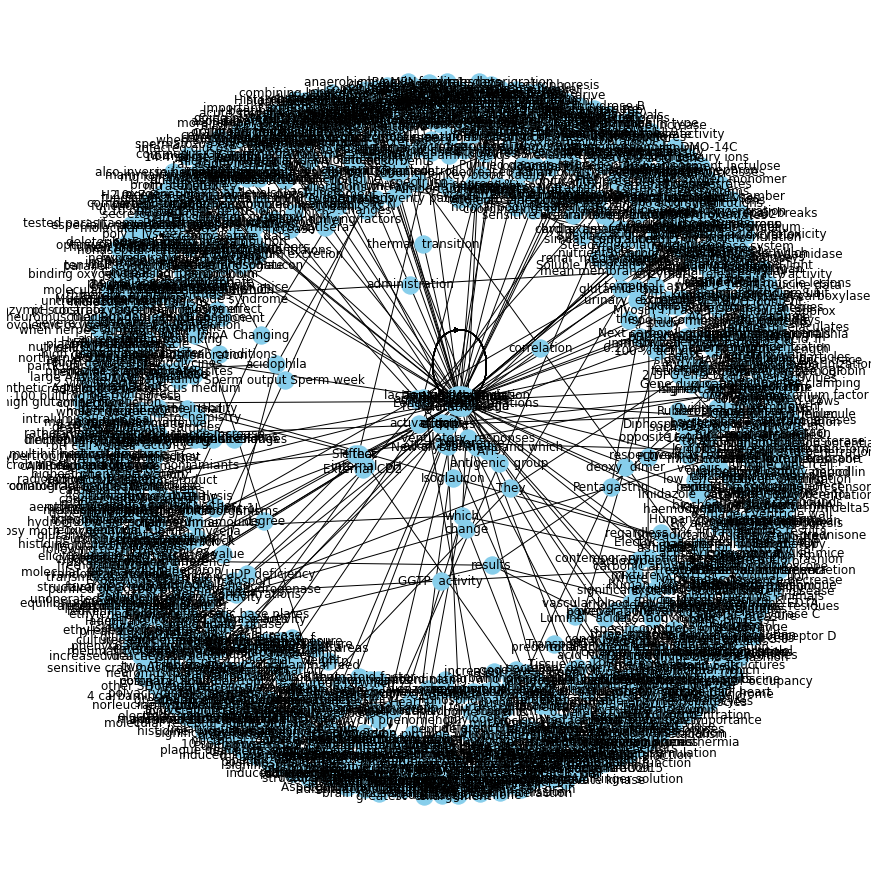

In [144]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

In [156]:
# [i for i in relations if i!='']

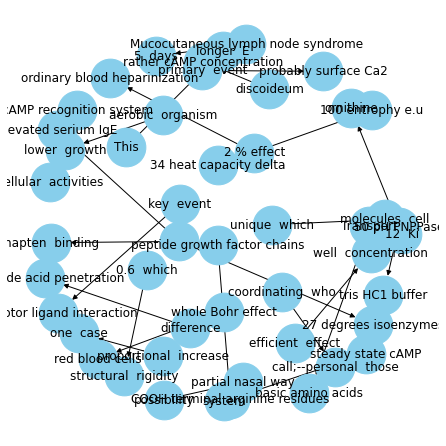

In [154]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=='is'], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(6,6))
pos = nx.spring_layout(G, k = 0.7) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

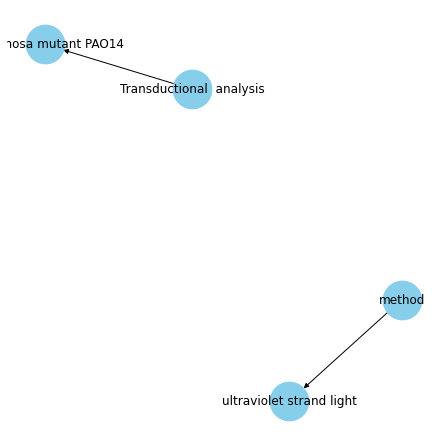

In [155]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=='applied to'], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(6, 6))
pos = nx.spring_layout(G, k = 0.7)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()